# PARTIE 4: Etude de l'impact des malus 2021 et 2024 sur les emissions de CO2 (en se basant sur le modele logit)
1. Travail sur les données
2. Estimation du CO2 réel avec un modele de machine learning (succes)
3. Calcul du parametre delta calibrant notre modele logit de consommation
4. Test de notre fonction logit part_de_marche avec le delta (succès): les parts de marché estimées avec le malus 2021 correspondent aux ventes 2021

5. Affichage de l'effet des différents malus sur les emissions moyennes de CO2 en se basant sur le modele logit
    (malus basé sur co2 théorique ou réel )

In [ ]:
import numpy as np
np.float=float
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
np.bool = bool
from sklearn.linear_model import Lasso
import re

## 1. Travail sur les données

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#/content/gdrive/MyDrive

In [ ]:
#file_path = '/content/gdrive/MyDrive/psc/data_BLP_caracteristics_CO2_corr.xlsx'

Base rsvero 2021

In [ ]:
#data = pd.read_excel(file_path)
data = pd.read_excel('data_BLP_caracteristics_CO2_corr.xlsx')

In [ ]:
columns=list(data.columns.values)
print(columns)

['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass', 'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree', 'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel', 'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile', 'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique', 'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr', 'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N']


Base ADEME 2021

In [ ]:
#file_path2 = '/content/gdrive/MyDrive/psc/ventes 2021_IPP.xlsx'
#data2=pd.read_excel(file_path2)
data2=pd.read_excel('ventes 2021_IPP.xlsx')

In [ ]:
data2.columns

Index(['DATE', 'Genre', 'Marque', 'Type', 'Puissance fiscale', 'Modèle',
       'Version', 'Carrosserie', 'Energie', 'Cylindrée', 'Gamme',
       'Poids à vide', 'Puissance KW', 'Rapport poid puissance',
       'Type de boite', 'Groupe', 'MF/ME', 'Consommation extra-urbaine',
       'Consommation mixte', 'Consommation urbaine', 'BONUS_MALUS',
       'Prix du véhicule', 'CO2_PRF', 'DATE_ARRETE', 'VOLUME', 'JO'],
      dtype='object')

In [ ]:
data.columns

Index(['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass',
       'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree',
       'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel',
       'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile',
       'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique',
       'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr',
       'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N'],
      dtype='object')

In [ ]:
data.rename(columns={'type_cnit': 'Type'}, inplace=True) #renomme le cnit

In [ ]:
new_data = pd.merge(data, data2, on='Type', how='inner') #fusionne les 2 par le cnit

In [ ]:
datap=new_data.loc[new_data['N']>20]
datap = datap[['mean_cylindree','mean_co2_theorique','mean_ptr', 'mean_charge_utile','mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels','Prix du véhicule','Carrosserie', 'VOLUME','CO2_PRF']]
print(datap)

       mean_cylindree  mean_co2_theorique  mean_ptr  mean_charge_utile  \
0              4806.0          286.000000    4700.0         530.000000   
1              1598.0          147.000000    2895.0         455.628490   
3              1582.0          108.000000    3420.0         560.456938   
4                 NaN            0.000000       NaN         385.000000   
5                 NaN            0.000000       NaN         470.000000   
...               ...                 ...       ...                ...   
54158           998.0          127.086957    2830.0         530.000000   
54202           999.0          126.750000    2690.0         499.750000   
54203           999.0          126.750000    2690.0         499.750000   
54204           999.0          126.750000    2690.0         499.750000   
54529          2894.0           76.782609       NaN         595.000000   

       mean_puis_kw  mean_co2_reel energ  mean_nb_decibels  Prix du véhicule  \
0        368.000000     358.498

In [ ]:
datap.dropna(inplace=True)
datap.describe()

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF
count,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000
mean,1626.548577,130.309693,3559.407031,592.092125,111.986209,154.535375,74.125434,39194.742269,34.497914,131.311487
std,464.653106,33.643105,775.139234,89.668620,40.426663,29.534750,3.708701,16394.487896,162.132949,34.722368
min,874.102052,0.000000,0.000000,224.074713,26.300000,0.000000,56.000000,8890.000000,1.000000,0.000000
25%,1332.000000,122.909563,2990.000000,540.735849,88.000000,142.348936,72.000000,28350.000000,1.000000,124.000000
50%,1499.000000,134.838150,3470.000000,575.000000,110.000000,155.775000,74.000000,36090.000000,4.000000,136.000000
75%,1968.000000,147.485714,3935.000000,615.840000,120.000000,168.852000,76.000000,45724.000000,14.000000,149.000000
max,5000.000000,373.000000,6850.000000,1243.000000,478.000000,405.892593,96.000000,205715.000000,6754.000000,373.000000


In [ ]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels',
       'Prix du véhicule', 'Carrosserie', 'VOLUME', 'CO2_PRF'],
      dtype='object')

In [ ]:
datap['energ'].unique()

array(['ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN', 'GL', 'EG', 'FH',
       'EN'], dtype=object)

In [ ]:
emissions_theoriques = 0
emissions_reelles = 0
ventes_totales = 0
valeurs_colonne_co2_reel = datap['mean_co2_reel']
valeurs_colonne_co2_theorique = datap['mean_co2_theorique']
valeurs_colonne_ventes = datap['VOLUME']

In [ ]:
np.sum(valeurs_colonne_ventes*valeurs_colonne_co2_reel)/np.sum(valeurs_colonne_ventes)

141.41995121496478

In [ ]:
np.sum(valeurs_colonne_ventes*datap['mean_co2_theorique'])/np.sum(valeurs_colonne_ventes)

119.14878070141394

## graphe joli

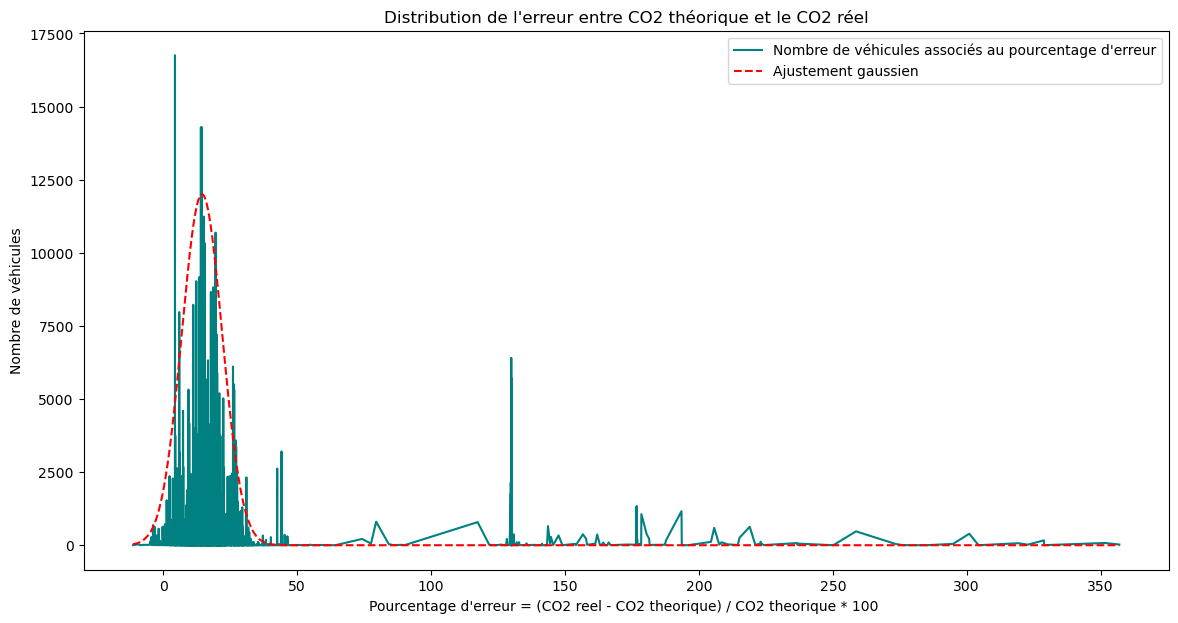

In [ ]:
data_co2=datap

data_co2['error_percentage'] = (data_co2['mean_co2_reel'] - data_co2['mean_co2_theorique'])/data_co2['mean_co2_theorique'] * 100
data_co2['error_percentage'].mean() 

volume_percentage_error=data_co2.groupby('error_percentage')['VOLUME'].sum()

# 'N' représente le nombre de véhicules vendus dans la DataFrame data_CO2
volume_percentage_error = data_co2.groupby('error_percentage')['VOLUME'].sum()

# Définition de la fonction gaussienne pour le fit
def gauss_function(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Utiliser les données de votre DataFrame
x = volume_percentage_error.index
y = volume_percentage_error.values

plt.figure(figsize=(14, 7))

# Tracer les données
plt.plot(volume_percentage_error.index, volume_percentage_error.values, color='teal', label='Nombre de véhicules associés au pourcentage d\'erreur')
plt.legend()
# Tracer la gaussienne ajustée
x0=data_co2['error_percentage'].mean() -12
sigma=data_co2['error_percentage'].std() *0.2
a=12000
plt.plot(x, gauss_function(x, a, x0, sigma), 'r--', label='Ajustement gaussien')
plt.legend()
plt.plot()
plt.xlabel('Pourcentage d\'erreur = (CO2 reel - CO2 theorique) / CO2 theorique * 100 ')
plt.ylabel('Nombre de véhicules')
plt.title('Distribution de l\'erreur entre CO2 théorique et le CO2 réel')
plt.show()


## Lien entre caractéristiques et émission de CO2

## Energie

In [ ]:
print(datap.columns)
#tableau liste_energ
liste_energ = ['ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN', 'GL', 'EG', 'FH','EN']

nb_vehicules=datap['VOLUME'].sum()
datap.groupby('energ')['VOLUME'].sum() / nb_vehicules * 100

nb_vehicules=datap.groupby('energ')['VOLUME'].sum()

co2foisVolume = datap.groupby('energ').apply(lambda x: (x['mean_co2_theorique'] * x['VOLUME']).sum())

print("\nCO2 théorique par energie")
co2th = co2foisVolume / nb_vehicules
print(co2th)

print("\nCO2 réel par energie")
co2foisVolume = datap.groupby('energ').apply(lambda x: (x['mean_co2_reel'] * x['VOLUME']).sum())
co2re = co2foisVolume / nb_vehicules
print(co2re)

print("\nErreur")
print((co2re - co2th)/co2th * 100)

## Carrosserie

In [ ]:
#tablau liste carroserie

liste_carroserie = ['BERLINE', 'TS TERRAINS/CHEMINS', 'BREAK',
       'MINIBUS', 'MONOSPACE COMPACT', 'COMBISPACE', 'COUPE', 'MONOSPACE',
       'MINISPACE', 'CABRIOLET']
nb_vehicules=datap['VOLUME'].sum()
datap.groupby('Carrosserie')['VOLUME'].sum() / nb_vehicules * 100
nb_vehicules=datap.groupby('Carrosserie')['VOLUME'].sum()

co2foisVolume = datap.groupby('Carrosserie').apply(lambda x: (x['mean_co2_theorique'] * x['VOLUME']).sum())

print("\nCO2 théorique par Carrosserie")
co2th = co2foisVolume / nb_vehicules
print(co2th)
print("\nCO2 réel par Carrosserie")
co2foisVolume = datap.groupby('Carrosserie').apply(lambda x: (x['mean_co2_reel'] * x['VOLUME']).sum())
co2re = co2foisVolume / nb_vehicules
print(co2re)

print("\nErreur")
print((co2re - co2th)/co2th * 100)

## 2. Estimation du CO2 réel avec le machine learning

In [ ]:
y=datap['mean_co2_reel']
dataOG=new_data['mean_co2_theorique']
dataEtat=datap['mean_co2_theorique']

for col in list(datap['energ'].unique()):
    datap[col]=(datap['energ']==col)*1

for col in list(datap['Carrosserie'].unique()):
    datap[col]=(datap['Carrosserie']==col)*1

datap_train = datap.loc[-datap['energ'].isin(['EL'])] # sans éléctrique

datap_train=datap_train.drop('energ', axis=1)
datap_train=datap_train.drop('Carrosserie', axis=1)
datap=datap.drop('energ', axis=1)
datap=datap.drop('Carrosserie', axis=1)
y_sel = datap_train['mean_co2_reel']
datap_train=datap_train.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule', ], axis=1)
datas=datap.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule'], axis=1)

def normalization(dataToNormalize):
    columns=list(dataToNormalize.columns) # liste colonnes
    scaler=preprocessing.StandardScaler()
    for col in columns:
        dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


normalization(datap_train)
normalization(datas)

x_train, x_test, y_train, y_test = train_test_split(datap_train, y_sel, test_size=0.2)
lasso_model = Lasso(alpha=0.2)
lasso_model.fit(x_train, y_train)
test_predictions_lasso = lasso_model.predict(x_test)

print(f"RMSE_model = {round(sqrt(mean_squared_error(y_test,test_predictions_lasso)),3)}")

print(f"R2_score_model = {round(r2_score(y_test, test_predictions_lasso),3)}")

datap['CO2reel'] = lasso_model.predict(datas)

datap.loc[datap['EL']==1, 'CO2reel']=0

CO2reel=datap['CO2reel']

/tmp/ipykernel_277/1175417484.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


RMSE_model = 9.255
R2_score_model = 0.902


## 3. Code du Malus 2021 et 2024

### Malus 2021

In [ ]:
file_path = '/content/gdrive/MyDrive/psc/malus_2021.xlsx'

In [ ]:
#malus_2021_df = pd.read_excel('/content/gdrive/MyDrive/psc/malus_2021.xlsx')
malus_2021_df = pd.read_excel('malus_2021.xlsx')
malus_2021_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True)

def malus_etat_2021(c):
    if int(c)<=132:
        return 0
    if int(c)>=219:
        return 30000
    else:
        return int( malus_2021_df.loc[malus_2021_df['CO2'] == int(c)]['Montant'])

In [ ]:
datap['malus_2021'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2021), errors='coerce')

In [ ]:
datap['malus_2021_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2021), errors='coerce')

### Malus 2024

In [ ]:
malus_2024_df = pd.read_excel('malus_2024.xlsx')

# https://www.service-public.fr/particuliers/vosdroits/F35947

malus_2024_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True) # colonnes ['CO2', 'Montant']

def malus_etat_2024(c):
    if int(c)<=117:
        return 0
    elif int(c)>=193:
        return 60000
    else:
        return int (malus_2024_df.loc[malus_2024_df['CO2'] == str(int(c))+' g']['Montant'])

In [ ]:
datap['malus_2024'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2024), errors='coerce')

In [ ]:
datap['malus_2024_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2024), errors='coerce')

## 3. Calcul du parametre delta calibrant notre modele logit de consommation

In [ ]:
p2021 = datap['Prix du véhicule'] + datap['malus_2021']

quantite = datap['VOLUME']

In [ ]:
quantite.describe()

count    39549.000000
mean        34.497914
std        162.132949
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       6754.000000
Name: VOLUME, dtype: float64

In [ ]:
beta = -0.00015
delta = beta*(p2021.iloc[len(p2021)-1]-p2021)+np.log(quantite/(quantite.iloc[len(quantite)-1]))

In [ ]:
datap['delta_modele'] = delta

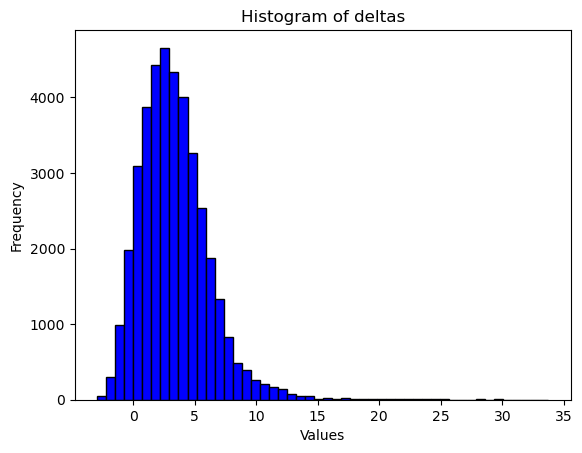

In [ ]:
# Assuming 'data' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.hist(datap['delta_modele'], bins=50, color='blue', edgecolor='black')  # You can adjust the number of bins and color
plt.title('Histogram of deltas')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


In [ ]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'mean_nb_decibels', 'Prix du véhicule',
       'VOLUME', 'CO2_PRF', 'ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN',
       'GL', 'EG', 'FH', 'EN', 'BERLINE', 'TS TERRAINS/CHEMINS', 'BREAK',
       'MINIBUS', 'MONOSPACE COMPACT', 'COMBISPACE', 'COUPE', 'MONOSPACE',
       'MINISPACE', 'CABRIOLET', 'CO2reel', 'malus_2021', 'malus_2021_reel',
       'malus_2024', 'malus_2024_reel', 'delta_modele'],
      dtype='object')

In [ ]:
#datap = datap[['mean_co2_theorique','mean_cylindree','nb_pl_ass', 'mean_co2_reel', 'energ','mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile','mean_puis_kw', 'Prix du véhicule', 'VOLUME','Carrosserie', 'malus_2021','delta_modele']]
datap

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF,...,COUPE,MONOSPACE,MINISPACE,CABRIOLET,CO2reel,malus_2021,malus_2021_reel,malus_2024,malus_2024_reel,delta_modele
0,4806.000000,286.000000,4700.0,530.000000,368.00000,358.498030,77.0,142807.0,1,286,...,0,0,0,0,331.491628,30000,30000,60000,60000,21.642903
1,1598.000000,147.000000,2895.0,455.628490,86.00000,181.021890,72.0,25254.0,1,147,...,0,0,0,0,164.551953,360,6039,1761,24291,-0.436047
3,1582.000000,108.000000,3420.0,560.456938,81.00000,151.611933,77.0,23905.0,1,108,...,0,0,0,0,125.806650,0,650,0,2370,-0.692397
7,1560.000000,100.000000,3160.0,569.984985,88.00000,140.958233,72.0,30371.0,1,100,...,0,0,0,0,121.142370,0,210,0,983,0.277503
9,1198.981607,104.000000,2366.0,570.998824,59.99908,149.158444,76.0,17736.0,1,104,...,0,0,0,0,127.419034,0,450,0,2049,-1.617747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54157,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29733.0,18,127,...,0,0,0,0,149.969020,0,740,240,2544,3.072175
54158,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29933.0,1,127,...,0,0,0,0,149.969020,0,740,240,2544,0.211803
54202,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,5,126,...,0,0,0,0,149.954037,0,190,230,898,0.755041
54203,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,21,127,...,0,0,0,0,150.115313,0,190,230,898,2.190125


In [ ]:
datap[['mean_co2_theorique','malus_2021']].corr()

,mean_co2_theorique,malus_2021
mean_co2_theorique,1.000000,0.476102
malus_2021,0.476102,1.000000


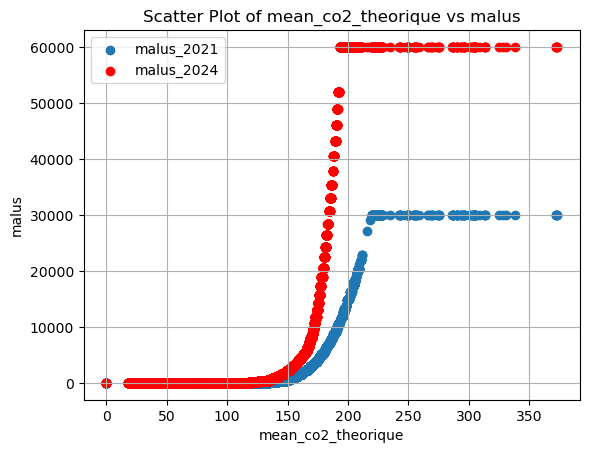

In [ ]:
plt.scatter(datap['mean_co2_theorique'], datap['malus_2021'], label='malus_2021')
plt.scatter(datap['mean_co2_theorique'], datap['malus_2024'], label='malus_2024', color='r')
plt.title('Scatter Plot of mean_co2_theorique vs malus')
plt.xlabel('mean_co2_theorique')
plt.ylabel('malus')
plt.grid(True)  # Optional: Adds a grid for better readability
plt.legend()
plt.show()

In [ ]:
print(datap['malus_2021'].mean())
print(np.average(datap['malus_2021'], weights=datap['VOLUME']))

698.8260891552252
187.87181296990966


## 4. Test de notre fonction part de marché (succès)

In [ ]:
def part_de_marche(m):
    pexp = np.exp(  datap['delta_modele'] + beta * (datap['Prix du véhicule'] + m))
    pit = pexp / np.sum(pexp)
    return pit


part_de_marche_estime = part_de_marche(datap['malus_2021'])
#part_de_marche_estime = part_de_marche(0)

part_de_marche_observe = datap['VOLUME']/datap['VOLUME'].sum()

print("malus 2021")
ecart = (part_de_marche_estime - part_de_marche_observe)/(part_de_marche_observe) * 100
print(ecart.describe())
print("Notre modele logit predit les ventes observees en 2021 lorsque l'on applique le malus 2021.")

malus 2021
count    3.954900e+04
mean    -5.035700e-16
std      4.523765e-14
min     -2.889140e-13
25%     -2.889140e-14
50%      0.000000e+00
75%      3.934149e-14
max      4.044797e-13
dtype: float64
Notre modele logit predit les ventes observees en 2021 lorsque l'on applique le malus 2021.


Formula based on initial shares and changes in prices: $s'_j=s_j \exp(\beta \times \Delta T_j)/\sum_h s_h \exp(\beta \times \Delta T_h)$

In [ ]:
def part_de_marche_v2(dT):
    s=datap['VOLUME']/datap['VOLUME'].sum()
    pexp = s*np.exp( beta * (dT))
    pit = pexp / np.sum(pexp)
    return pit

part_de_marche_estime_v2 = part_de_marche_v2(-datap['malus_2021'])

# check the two approaches are consistent

#here important : cancelling the malus in the function part_de_marche is like adding m = 0 to the price
part_de_marche_estime = part_de_marche(0)
ecart = (part_de_marche_estime - part_de_marche_estime_v2)/(part_de_marche_estime_v2) * 100
print(ecart.describe())

count    3.954900e+04
mean     1.182435e-14
std      4.522556e-14
min     -2.674432e-13
25%     -1.567348e-14
50%      1.518746e-14
75%      4.179596e-14
max      4.234517e-13
dtype: float64


In [ ]:
nb_vehicules = datap['VOLUME'].sum()
moyenne_emission_reelle = np.sum(valeurs_colonne_ventes*valeurs_colonne_co2_reel)/np.sum(valeurs_colonne_ventes)
moyenne_emission_reelle_estimee = (part_de_marche(0)* datap['mean_co2_reel'] ).sum()
print("emission reelle observee:",moyenne_emission_reelle)
print("emission reelle estimée sans malus:",moyenne_emission_reelle_estimee)

emission reelle observee: 141.41995121496478
emission reelle estimée sans malus: 150.40915478663536


In [ ]:
nb_vehicules = datap['VOLUME'].sum()
moyenne_emission_reelle = np.sum(valeurs_colonne_ventes*datap['mean_co2_theorique'])/np.sum(valeurs_colonne_ventes)
moyenne_emission_reelle_estimee = (part_de_marche(0)* datap['mean_co2_theorique'] ).sum()
print("emission theorique observee:",moyenne_emission_reelle)
print("emission theorique estimée sans malus:",moyenne_emission_reelle_estimee)

emission theorique observee: 119.14878070141394
emission theorique estimée sans malus: 127.25666262501068


In [ ]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'mean_nb_decibels', 'Prix du véhicule',
       'VOLUME', 'CO2_PRF', 'ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN',
       'GL', 'EG', 'FH', 'EN', 'BERLINE', 'TS TERRAINS/CHEMINS', 'BREAK',
       'MINIBUS', 'MONOSPACE COMPACT', 'COMBISPACE', 'COUPE', 'MONOSPACE',
       'MINISPACE', 'CABRIOLET', 'CO2reel', 'malus_2021', 'malus_2021_reel',
       'malus_2024', 'malus_2024_reel', 'delta_modele'],
      dtype='object')

## 5. Calcul de notre malus (fait dans le fichier optimisation)

## 6. Affichage de l'effet des différents malus sur les emissions moyennes de CO2

In [ ]:
m_guess = np.zeros(datap['VOLUME'].size)
m_guess

array([0., 0., 0., ..., 0., 0., 0.])

### Effet malus 2021 basé sur CO2 théorique

In [ ]:
# categorisation selon le malus 2021 théorique
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_theorique'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2021=datap.groupby('CO2bins')['malus_2021'].mean() #2021 sur theorique

#### a. Visualisation du malus 2021

/tmp/ipykernel_277/1947734070.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  make_int_vf = np.vectorize(np.int)


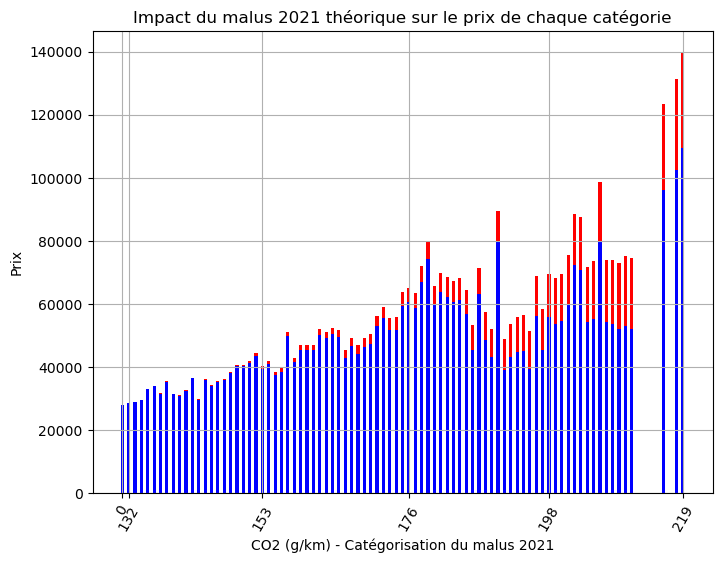

In [ ]:
# Créer le graphe
plt.figure(figsize=(8, 6))

# Tracer les barres

plt.bar(range(len(p)), p+malus_2021, width=0.5, align='center', color='red')
plt.bar(range(len(p)), p, width=0.5, align='center', color='blue')

make_int_vf = np.vectorize(np.int)

# Définir les limites des axes x et y

positions = [0, 1, len(bins_limits) //4, len(bins_limits) // 2, 3*len(bins_limits) // 4, len(bins_limits) - 2]  # Par exemple, afficher la première, la moitié et la dernière valeur
labels = [make_int_vf(bins_limits[i]) for i in positions]
plt.xticks(positions, labels, rotation=60)
#plt.xticks(range(len(bins_limits)), make_int_vf(bins_limits), rotation =60)
plt.xlabel('CO2 (g/km) - Catégorisation du malus 2021')
plt.ylabel('Prix')

# Ajouter des titres et des légendes
plt.title('Impact du malus 2021 théorique sur le prix de chaque catégorie')
plt.grid(True)

# Afficher le graphe
plt.show()

#### b. impact en terme de moyenne d'émissions

In [ ]:
malus_2021

CO2bins
[0, 132)          0.0
[132, 133)        0.0
[133, 134)       50.0
[134, 135)       75.0
[135, 136)      100.0
               ...   
[215, 216)        NaN
[216, 217)    27166.0
[217, 218)        NaN
[218, 219)    29070.0
[219, 420)    30000.0
Name: malus_2021, Length: 89, dtype: float64

In [ ]:

print("MALUS 2021 basé sur CO2 théorique")
print("\nCO2 théorique après application du malus 2021 théorique")
# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# i- moyenne co2 théorique (pondérée par parts de marché observées)
observe = (datap['mean_co2_theorique']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 théorique (observée): ', observe )


# ii- moyenne co2 théorique (pondérée par parts de marché contrefactuelles sans malus)
estimation_sans_malus = ( datap['mean_co2_theorique'] * part_de_marche(m_guess)).sum()
estimation_avec_malus2021 = ( datap['mean_co2_theorique'] * part_de_marche(datap['malus_2021'])).sum()
print('Moyenne co2 théorique (estimée sans malus): ',  estimation_sans_malus)
print('Moyenne co2 théorique (estimée avec malus 2021): ',  estimation_avec_malus2021)

# iii- baisse en pourcent permis grâce au malus en CO2 théorique ((observé-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 théorique: ', ((estimation_sans_malus - estimation_avec_malus2021)/estimation_avec_malus2021)*100)


# pour 2021 dans datap
print("\nCO2 réel après application du malus 2021 théorique")
nb_vehicules = datap['VOLUME'].sum()

# iv- moyenne co2 réel (pondérée par parts de marché observées)
observe = (datap['mean_co2_reel']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 réel (observée): ', observe )

# comparaison realite / estimation
estimation_sans_malus = ( datap['mean_co2_reel'] * part_de_marche(m_guess)).sum()
print('Moyenne co2 réel (estimée sans malus): ',  estimation_sans_malus)

# v- moyenne co2 réel (pondérée par parts de marché contrefactuelles sans malus)
estimation_avec_malus2021 = ( datap['mean_co2_reel'] * part_de_marche(datap['malus_2021'])).sum()
print('Moyenne co2 réel (estimée avec malus 2021): ',  estimation_avec_malus2021)

# vi- baisse en pourcent permis grâce au malus en CO2 réel ((observée-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 réel: ', ((estimation_sans_malus - estimation_avec_malus2021)/estimation_avec_malus2021)*100)


MALUS 2021 basé sur CO2 théorique

CO2 théorique après application du malus 2021 théorique
Moyenne co2 théorique (observée):  119.14878070141394
Moyenne co2 théorique (estimée sans malus):  127.25666262501068
Moyenne co2 théorique (estimée avec malus 2021):  119.14878070141397
Baisse en pourcentage des emissions grace au malus en co2 théorique:  6.804838350729753

CO2 réel après application du malus 2021 théorique
Moyenne co2 réel (observée):  141.41995121496478
Moyenne co2 réel (estimée sans malus):  150.40915478663536
Moyenne co2 réel (estimée avec malus 2021):  141.4199512149648
Baisse en pourcentage des emissions grace au malus en co2 réel:  6.356389953781375


## effet malus 2021 basé sur le co2 réel

In [ ]:
# categorisation selon le malus 2021 réel
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False) #CO2 réel
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

malus_2021_reel = datap.groupby('CO2bins')['malus_2021_reel'].min()
malus_2021_reel



CO2bins
[0, 132)          0
[132, 133)        0
[133, 134)       50
[134, 135)       75
[135, 136)      100
              ...  
[215, 216)    26247
[216, 217)    27166
[217, 218)    28107
[218, 219)    29070
[219, 420)    30000
Name: malus_2021_reel, Length: 89, dtype: int64

In [ ]:

print("MALUS 2021 basé sur CO2 réel")
print("\nCO2 théorique")
# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# i- moyenne co2 théorique (pondérée par parts de marché observées)
observe = (datap['mean_co2_theorique']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 théorique (observée): ', observe )


# ii- moyenne co2 théorique (pondérée par parts de marché contrefactuelles sans malus)
estimation_sans_malus = ( datap['mean_co2_theorique'] * part_de_marche(m_guess)).sum()
estimation_avec_malus2021 = ( datap['mean_co2_theorique'] * part_de_marche(datap['malus_2021_reel'])).sum()
print('Moyenne co2 théorique (estimée sans malus): ',  estimation_sans_malus)
print('Moyenne co2 théorique (estimée avec malus 2021): ',  estimation_avec_malus2021)

# iii- baisse en pourcent permis grâce au malus en CO2 théorique ((observé-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 théorique: ', ((estimation_sans_malus - estimation_avec_malus2021)/estimation_avec_malus2021)*100)


# pour 2021 dans datap
print("\nCO2 réel")
nb_vehicules = datap['VOLUME'].sum()

# iv- moyenne co2 réel (pondérée par parts de marché observées)
observe = (datap['mean_co2_reel']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 réel (observée): ', observe )

# comparaison realite / estimation
estimation_sans_malus = ( datap['mean_co2_reel'] * part_de_marche(m_guess)).sum()
print('Moyenne co2 réel (estimée sans malus): ',  estimation_sans_malus)

# v- moyenne co2 réel (pondérée par parts de marché contrefactuelles sans malus)
estimation_avec_malus2021 = ( datap['mean_co2_reel'] * part_de_marche(datap['malus_2021_reel'])).sum()
print('Moyenne co2 réel (estimée avec malus 2021): ',  estimation_avec_malus2021)

# vi- baisse en pourcent permis grâce au malus en CO2 réel ((observée-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 réel: ', ((estimation_sans_malus - estimation_avec_malus2021)/estimation_avec_malus2021)*100)



MALUS 2021 basé sur CO2 réel

CO2 théorique
Moyenne co2 théorique (observée):  119.14878070141394
Moyenne co2 théorique (estimée sans malus):  127.25666262501068
Moyenne co2 théorique (estimée avec malus 2021):  116.5916895818876
Baisse en pourcentage des emissions grace au malus en co2 théorique:  9.1472840657589

CO2 réel
Moyenne co2 réel (observée):  141.41995121496478
Moyenne co2 réel (estimée sans malus):  150.40915478663536
Moyenne co2 réel (estimée avec malus 2021):  138.21499959449582
Baisse en pourcentage des emissions grace au malus en co2 réel:  8.822599014517628


### Effet malus 2024

In [ ]:
datap['malus_2024']

0        60000
1         1761
3            0
7            0
9            0
         ...  
54157      240
54158      240
54202      230
54203      230
54204      230
Name: malus_2024, Length: 39549, dtype: int64

#### a. Visualisation du malus 2024 basé sur le co2 théorique

In [ ]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
make_int_vf(malus_2024_df['CO2'][1:-1].values)

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

In [ ]:
# categorisation selon le malus 2024 sur co2 théorique
bins_limits = np.concatenate([np.array([0, 117])] + [make_int_vf(malus_2024_df['CO2'][1:-1].values)] + [np.array([ 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_theorique'], bins=bins_limits, include_lowest=True, right=False) #co2 theorique
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2024=datap.groupby('CO2bins')['malus_2024'].max()

In [ ]:
malus_2024

CO2bins
[0, 117)          0
[117, 118)        0
[118, 119)       50
[119, 120)       75
[120, 121)      100
              ...  
[189, 190)    43179
[190, 191)    45990
[191, 192)    48901
[192, 193)    51912
[193, 420)    60000
Name: malus_2024, Length: 78, dtype: int64

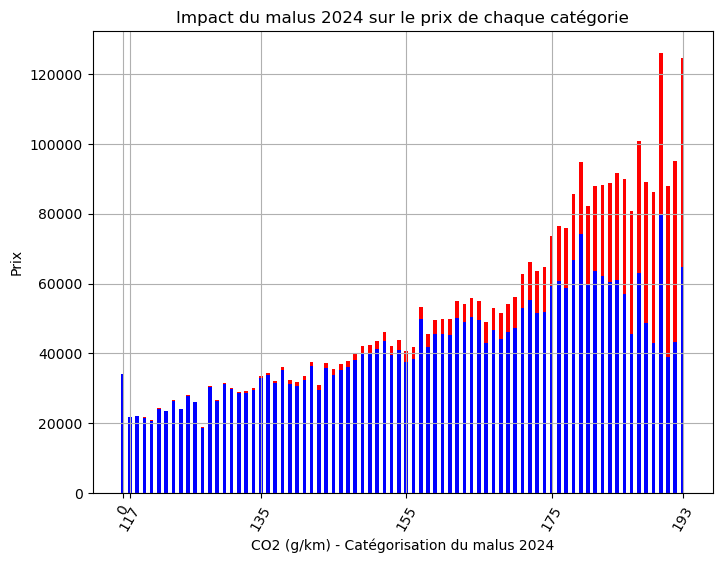

In [ ]:
# Créer le graphe
plt.figure(figsize=(8, 6))

# Tracer les barres

plt.bar(range(len(p)), p+malus_2024, width=0.5, align='center', color='red')
plt.bar(range(len(p)), p, width=0.5, align='center', color='blue')

make_int_vf = np.vectorize(int)

# Définir les limites des axes x et y

positions = [0, 1, len(bins_limits) //4, len(bins_limits) // 2, 3*len(bins_limits) // 4, len(bins_limits) - 2]  # Par exemple, afficher la première, la moitié et la dernière valeur
labels = [make_int_vf(bins_limits[i]) for i in positions]
plt.xticks(positions, labels, rotation=60)
#plt.xticks(range(len(bins_limits)), make_int_vf(bins_limits), rotation =60)
plt.xlabel('CO2 (g/km) - Catégorisation du malus 2024')
plt.ylabel('Prix')

# Ajouter des titres et des légendes
plt.title('Impact du malus 2024 sur le prix de chaque catégorie')
plt.grid(True)

# Afficher le graphe
plt.show()

#### b. Impact sur les moyennes d'émissions de CO2

In [ ]:


print(" MALUS 2024 basé sur co2 théorique")
print("\nCO2 théorique")

# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# i- moyenne co2 théorique (pondérée par parts de marché observées)
observe = (datap['mean_co2_theorique']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 théorique (observée): ', observe )


# ii- moyenne co2 théorique (pondérée par parts de marché contrefactuelles sans malus)
estimation_sans_malus = ( datap['mean_co2_theorique'] * part_de_marche(m_guess)).sum()
estimation_avec_malus2024 = ( datap['mean_co2_theorique'] * part_de_marche(datap['malus_2024'])).sum()
print('Moyenne co2 théorique (estimée sans malus): ',  estimation_sans_malus)
print('Moyenne co2 théorique (estimée avec malus 2024): ',  estimation_avec_malus2024)

# iii- baisse en pourcent permis grâce au malus en CO2 théorique ((observé-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 théorique: ', ((estimation_sans_malus - estimation_avec_malus2024)/estimation_avec_malus2024)*100)


print("\nCO2 réel")
# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# iv- moyenne co2 réel (pondérée par parts de marché observées)
observe = (datap['mean_co2_reel']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 réel (observée): ', observe )

# comparaison realite / estimation
estimation_sans_malus = ( datap['mean_co2_reel'] * part_de_marche(m_guess)).sum()
print('Moyenne co2 réel (estimée sans malus): ',  estimation_sans_malus)

# v- moyenne co2 réel (pondérée par parts de marché contrefactuelles sans malus)
estimation_avec_malus2024 = ( datap['mean_co2_reel'] * part_de_marche(datap['malus_2024'])).sum()
print('Moyenne co2 réel (estimée avec malus 2024): ',  estimation_avec_malus2024)

# vi- baisse en pourcent permis grâce au malus en CO2 réel ((observée-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 réel: ', ((estimation_sans_malus - estimation_avec_malus2024)/estimation_avec_malus2024)*100)


 MALUS 2024 basé sur co2 théorique

CO2 théorique
Moyenne co2 théorique (observée):  119.14878070141394
Moyenne co2 théorique (estimée sans malus):  127.25666262501068
Moyenne co2 théorique (estimée avec malus 2024):  117.19696086493403
Baisse en pourcentage des emissions grace au malus en co2 théorique:  8.58358585908226

CO2 réel
Moyenne co2 réel (observée):  141.41995121496478
Moyenne co2 réel (estimée sans malus):  150.40915478663536
Moyenne co2 réel (estimée avec malus 2024):  139.61691984974533
Baisse en pourcentage des emissions grace au malus en co2 réel:  7.729890437709518


## malus 2024 sur co2 réel

In [ ]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
liste_bins_malus_2024 = make_int_vf(malus_2024_df['CO2'][1:-1].values)
liste_bins_malus_2024

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

In [ ]:
# categorisation selon le malus 2024 sur co2 réel
bins_limits = np.concatenate([np.array([0, 117])] + [liste_bins_malus_2024] + [np.array([ 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2024_reel=datap.groupby('CO2bins')['malus_2024_reel'].mean()

In [ ]:
malus_2024_reel

CO2bins
[0, 117)          0.0
[117, 118)        0.0
[118, 119)       50.0
[119, 120)       75.0
[120, 121)      100.0
               ...   
[189, 190)    43179.0
[190, 191)    45990.0
[191, 192)    48901.0
[192, 193)    51912.0
[193, 420)    60000.0
Name: malus_2024_reel, Length: 78, dtype: float64

In [ ]:


print(" MALUS 2024 basé sur co2 réel")
print("\nCO2 théorique")

# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# i- moyenne co2 théorique (pondérée par parts de marché observées)
observe = (datap['mean_co2_theorique']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 théorique (observée): ', observe )


# ii- moyenne co2 théorique (pondérée par parts de marché contrefactuelles sans malus)
estimation_sans_malus = ( datap['mean_co2_theorique'] * part_de_marche(m_guess)).sum()
estimation_avec_malus2024 = ( datap['mean_co2_theorique'] * part_de_marche(datap['malus_2024_reel'])).sum()
print('Moyenne co2 théorique (estimée sans malus): ',  estimation_sans_malus)
print('Moyenne co2 théorique (estimée avec malus 2024): ',  estimation_avec_malus2024)

# iii- baisse en pourcent permis grâce au malus en CO2 théorique ((observé-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 théorique: ', ((estimation_sans_malus - estimation_avec_malus2024)/estimation_avec_malus2024)*100)


print("\nCO2 réel")
# pour 2021 dans datap
nb_vehicules = datap['VOLUME'].sum()

# iv- moyenne co2 réel (pondérée par parts de marché observées)
observe = (datap['mean_co2_reel']*datap['VOLUME']).sum() / nb_vehicules
print('Moyenne co2 réel (observée): ', observe )

# comparaison realite / estimation
estimation_sans_malus = ( datap['mean_co2_reel'] * part_de_marche(m_guess)).sum()
print('Moyenne co2 réel (estimée sans malus): ',  estimation_sans_malus)

# v- moyenne co2 réel (pondérée par parts de marché contrefactuelles sans malus)
estimation_avec_malus2024 = ( datap['mean_co2_reel'] * part_de_marche(datap['malus_2024_reel'])).sum()
print('Moyenne co2 réel (estimée avec malus 2024): ',  estimation_avec_malus2024)

# vi- baisse en pourcent permis grâce au malus en CO2 réel ((observée-contrefactuel)/contrefactuel)
print('Baisse en pourcentage des emissions grace au malus en co2 réel: ', ((estimation_sans_malus - estimation_avec_malus2024)/estimation_avec_malus2024)*100)


 MALUS 2024 basé sur co2 réel

CO2 théorique
Moyenne co2 théorique (observée):  119.14878070141394
Moyenne co2 théorique (estimée sans malus):  127.25666262501068
Moyenne co2 théorique (estimée avec malus 2024):  112.40904041958981
Baisse en pourcentage des emissions grace au malus en co2 théorique:  13.208565921387697

CO2 réel
Moyenne co2 réel (observée):  141.41995121496478
Moyenne co2 réel (estimée sans malus):  150.40915478663536
Moyenne co2 réel (estimée avec malus 2024):  133.68893819093927
Baisse en pourcentage des emissions grace au malus en co2 réel:  12.506806338618444


In [ ]:
malus_2024_reel

CO2bins
[0, 117)          0.0
[117, 118)        0.0
[118, 119)       50.0
[119, 120)       75.0
[120, 121)      100.0
               ...   
[189, 190)    43179.0
[190, 191)    45990.0
[191, 192)    48901.0
[192, 193)    51912.0
[193, 420)    60000.0
Name: malus_2024_reel, Length: 78, dtype: float64